***Note: this is the ECR.ipynb notebook. The
PDF version "Enzyme-catalysed Reactions"
is available [here](ECR.pdf).***

# Introduction
The standard model of an enzyme-catalysed reaction is given by 
<cite data-cite="KeeSne09">(Keener and Sneyd, 2009)</cite>, Sec. 1.4 is given by the two coupled reactions:
\begin{align}
A + E &\Leftrightarrow C \\
C &\rightarrow B + E 
\end{align}
where A is the substrate, B the product, E the enzyme and C a complex. The first reaction is reversible and the second is not. This is not thermodynamically feasible so <cite data-cite="KeeSne09">(Keener and Sneyd, 2009)</cite>, Sec. 1.4.5 and 
<cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite>
consider the reversible reaction pair:
\begin{align}
A + E &\Leftrightarrow C \\
C &\Leftrightarrow B + E 
\end{align}
Such a reaction pair is thermodynamically feasible and so has a bond graph representation given by <cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite> Sec. 5. The corresponding flow $v$ is given by:
\begin{align}
 v &= \bar{\kappa} \frac{K_c e_0}{K_m +  \sigma_v} \delta_v\\
 \text{where }
 \bar{\kappa} &= \frac{\kappa_1 \kappa_2}{{\kappa_1+\kappa_2}}\\
 \delta_v &= K_A x_A - K_B x_B\\
 K_m &= \frac{K_c}{K_e}\\
 \text{and }
 \sigma_v &= \frac{\kappa_1 K_A x_A + \kappa_2 K_B x_B}{\kappa_1+\kappa_2}
\end{align}

## Implement the theory
The flow equations can be expressed in Python as:

In [1]:
def ECR_flow(x_A,x_B,e0=1,
             K_A = 1,K_B=1,K_C=1,K_E=1,
             kappa_r1 = 1,kappa_r2=1):
    """Theoretical flows in Enzyme-catalysed Reactions
    """
    
    kappa_bar = (kappa_r1*kappa_r2)/(kappa_r1+kappa_r2)
    delta = K_A*x_A - K_B*x_B
    sigma = (kappa_r1*K_A*x_A + kappa_r2*K_B*x_B)/(kappa_r1 + kappa_r2)
    K_m = K_C/K_E
    
    v = kappa_bar*e0*K_C*delta/(K_m+sigma)
    
    return v

## Import some python code
The bond graph analysis uses a number of Python modules:

In [2]:
## Some useful imports
import BondGraphTools as bgt
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import IPython.display as disp

## Stoichiometric analysis
import stoich as st

## SVG bg representation conversion
import svgBondGraph as sbg

## Set quiet=False for verbose output
quiet = True

# The bond graph representation
The bond graph representation of the (reversible) enzyme-catalysed reaction is
<cite data-cite="GawCra14">(Gawthrop and Crampin, 2014)</cite>:

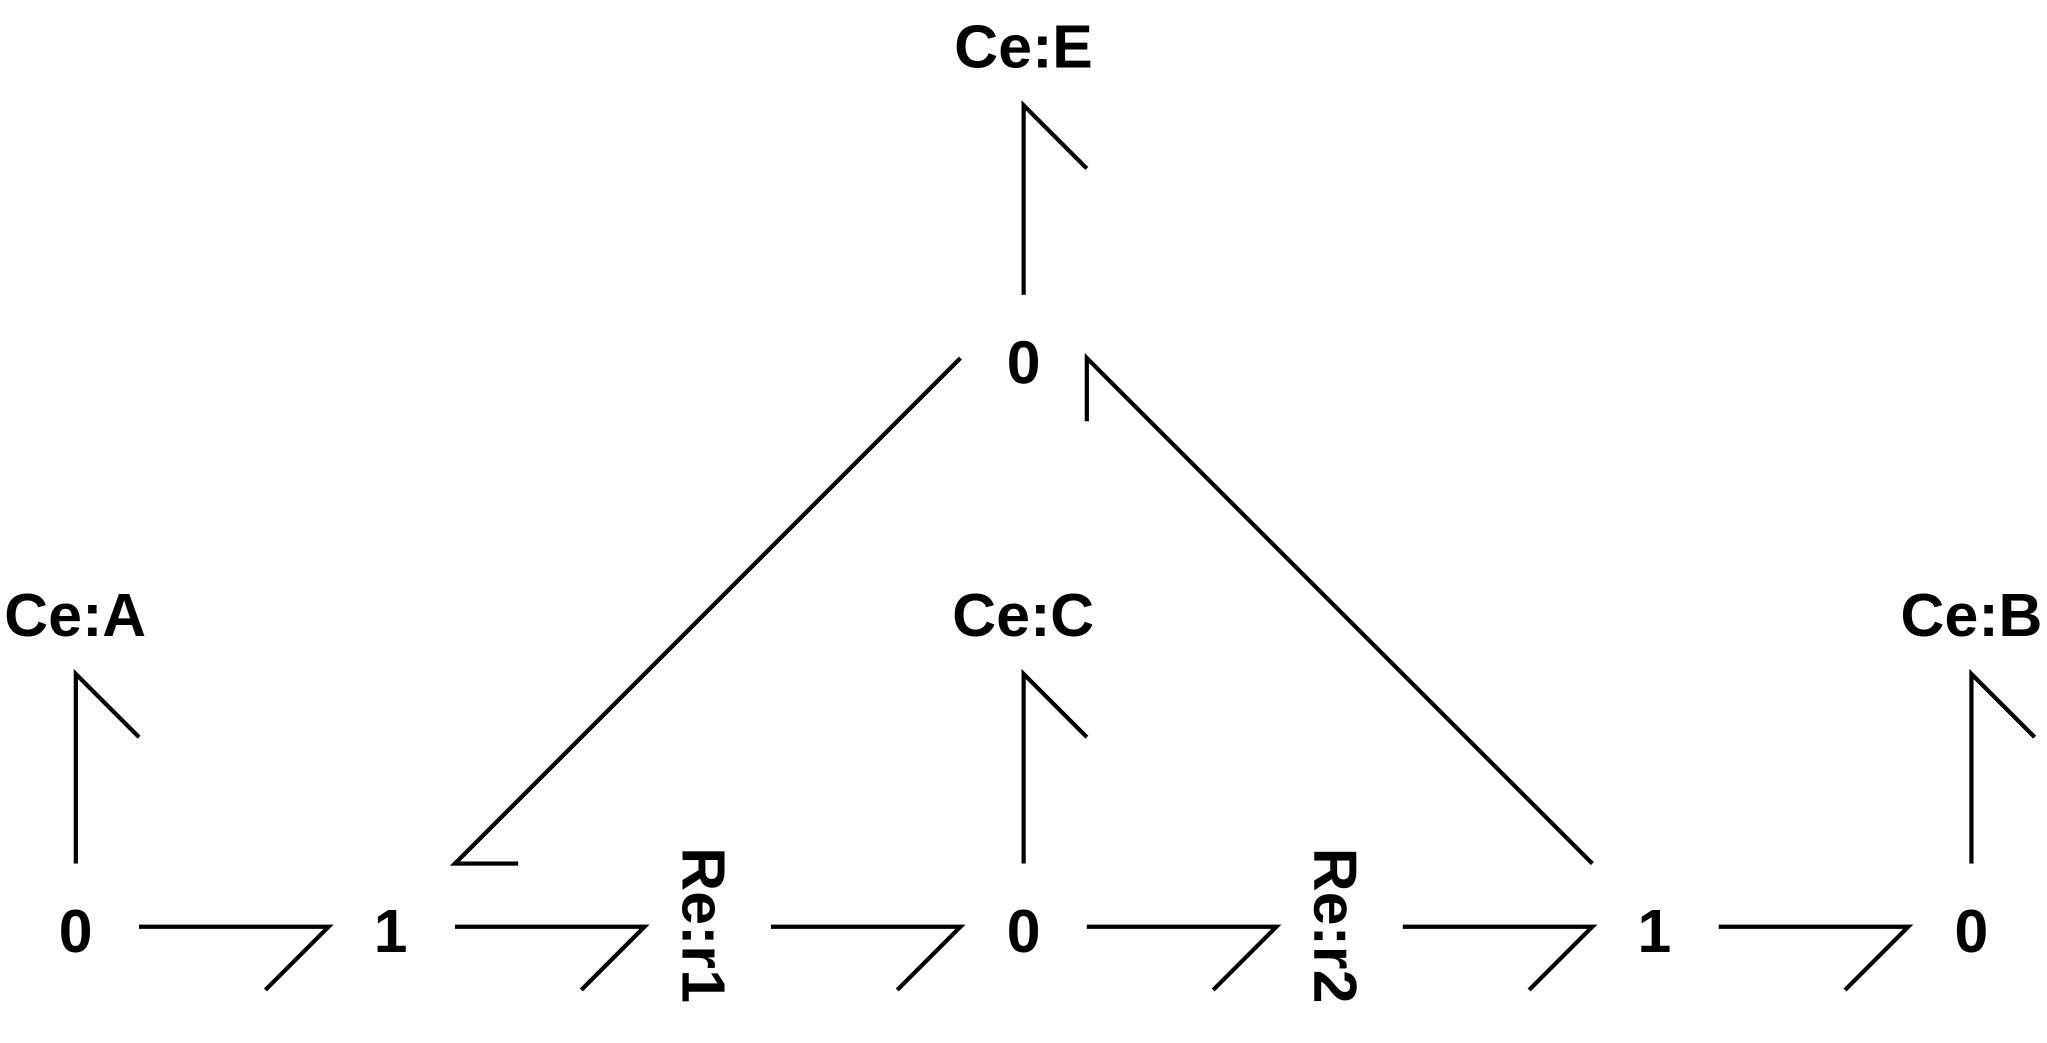

In [3]:
## Enzyme-catalysed reaction

disp.SVG('RE_abg.svg')

This graphical representation may be converted to [bond-graph tools](https://pypi.org/project/BondGraphTools/) format using 

In [4]:
sbg.model('RE_abg.svg')
import RE_abg

## Reactions
The reactions coreponding to this bond graph are generated as follows:

In [5]:
s = st.stoich(RE_abg.model(),quiet=quiet)
disp.Latex(st.sprintrl(s,chemformula=True))

<IPython.core.display.Latex object>

# Stoichiometric analysis

## Stoichiometric matrix

In [6]:
disp.Latex(st.sprintl(s,'N'))

<IPython.core.display.Latex object>

## Conserved moieties

In [7]:
disp.Latex(st.sprintl(s,'G'))

<IPython.core.display.Latex object>

## Chemostats and Pathways
Chemostats are discussed by <cite data-cite="GawCra16">(Gawthrop and Crampin, 2016)</cite> and pathways by <cite data-cite="GawCra17">(Gawthrop and Crampin, 2017)</cite>

In [8]:
chemostats = ['A','B']
sc = st.statify(s,chemostats=chemostats)
disp.Latex(st.sprintl(sc,'K'))

<IPython.core.display.Latex object>

In [9]:
sp = st.path(s,sc)
disp.Latex(st.sprintrl(sp,chemformula=True))

<IPython.core.display.Latex object>

# Theoretical flows
The theoretical flows are generated as a function of x_A (with constant x_B) for two values of $K_B$ and two values of $K_E$. $K_B=0$ corresponds to the irreversible case.

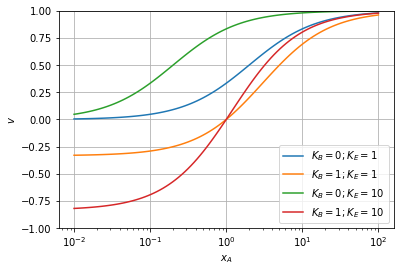

In [10]:
KK_E = [1,10]
KK_B = [0,1]
Legend = []
x_A = np.logspace(-2,2,100)
x_B = 1
for K_E in KK_E:
    for K_B in KK_B:
        Legend.append('$K_B = '+str(K_B)+'; K_E = '+str(K_E)+'$')
        v = ECR_flow(x_A,x_B,K_E=K_E,K_B=K_B)
        plt.semilogx(x_A,v)
plt.legend(Legend)
plt.ylim((-1,1))
plt.xlabel('$x_A$')
plt.ylabel('$v$')
plt.grid()
plt.show()

Note:
    
    1. When $K_B=0$, the flow $v$  depends on $x_A$ but not $x_B$
    2. As $K_m = \frac{K_c}{K_e}$ the two cases correspond to $K_m=1$ and $K_m=0.1$ respectively. A smaller $K_m$ leads to a steeper curve. 

# Simulated flows
The theoretical values can be confirmed by simulation. However, the simulation is dynamic whereas the theoretical results correspond to the steady-state situation. This dichotomy is resolved by:

1. Starting x_A at a constant value to allow the transient effects of initial conditions to die out.
2. Then varying $x_A$ slowly:
\begin{equation}
x_A = 
   \begin{cases}
   x_{min} & \text{if $t<t_0$}\\
   x_{min} + (x_{max}-x_{min})\frac{t-t_0}{t_{max}-t_0} & \text{otherwise}
   \end{cases}
\end{equation}
3. It is not possible to set $K_B$ to zero as $\ln K_B x_B$ is not defined in this case. Hence a small value is used instead.

0.01 + (100.0-0.01)*np.heaviside(t-100.0,1)*((t-100.0)/99900.0)


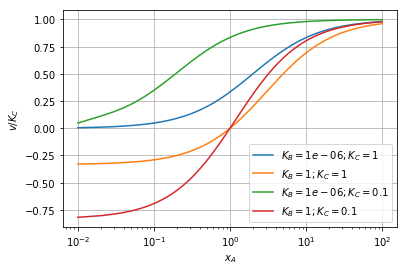

In [11]:
##Time
t_max = int(1e5)
t = np.linspace(0,t_max,10000)
t_0 = 1e2
t_1 = t_max-t_0
i_max = len(t)
i_0 = int(i_max*t_0/t_max)
i_1 = i_max-i_0

## States
x_min = 1e-2
x_max = 1e2
A_chemo = '{3} + ({0}-{3})*np.heaviside(t-{1},1)*((t-{1})/{2})'.format(x_max,t_0,t_1,x_min)
#A_chemo = '1+t/1e5'
print(A_chemo)
X_chemo =  {'A':A_chemo}
X0 = np.ones(s['n_X'])
X0[s['spec_index']['E']] = 0.5
X0[s['spec_index']['C']] = 0.5

## Simulate
Legend = []
for K_C in [1,0.1]:
    for K_B in [1E-6,1]:
        Legend.append('$K_B = '+str(K_B)+'; K_C = '+str(K_C)+'$')
        parameter = {'K_B':K_B,'K_C':K_C}
        dat = st.sim(s,sc=sc,t=t,parameter=parameter,X0=X0,X_chemo=X_chemo,quiet=quiet)
        v = dat['V'][:,s['reac_index']['r1']]
        x_A = dat['X'][:,s['spec_index']['A']]
        plt.semilogx(x_A[-i_1:],v[-i_1:]/K_C)
plt.legend(Legend)
#plt.ylim((-1,1))
plt.xlabel('$x_A$')
plt.ylabel('$v/K_C$')
plt.grid()
plt.show()

## Slowly-varying $x_A$
This section explicitly shows the approach used to generate steady-state values using a slowly-varying signal.
The first graph below shows the exogenous variable $x_A$: it has a constant value of 0.01  for $t<100$ and then rises as a slow ramp. The flow $v$ has a transient which settles well before $t=100$. In the above graphs, $v$ is plotted against $x_A$ for $t>100$ so that the initial transient does not appear.

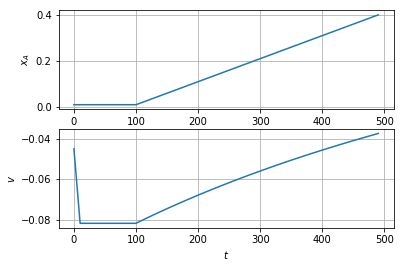

In [12]:
plt.subplot(2,1,1)
plt.plot(t[:5*i_0],x_A[:5*i_0])
plt.xlabel('$t$')
plt.ylabel('$x_A$')
plt.grid()
plt.subplot(2,1,2)
plt.plot(t[:5*i_0],v[:5*i_0])
plt.xlabel('$t$')
plt.ylabel('$v$')
plt.grid()
plt.show()